# Spam Detection

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

# text processing
import spacy

In [2]:
# load the data
msgs = pd.read_csv("SMSSpamCollection.csv", sep='\t', names=['Label', 'Message'])

# Rearrange the columns
msgs = msgs[['Message', 'Label']]
msgs.head()

,Message,Label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [3]:
### Helper Functions

def clean_doc(my_str):
    """
    1. Convert my_str to doc (collection of spans).
    2. Remove the stopwords and punctuations from the token_list and store in filtered_tokens.
    3. Return filtered_tokens.
    """
    
    stop_words = nlp.Defaults.stop_words    # stopwords
    
   # convert to doc
    doc = nlp(my_str)
    
    # filtered tokens which have been converted to strings and remove the punctuations
    filtered_tokens = [str(token) for token in doc if token.is_stop == False and token.is_punct == False]
    
    return filtered_tokens


def punct_length(msg):
    """
    1. Tokenize the msg and check if the token is a punctuation.
    2. If it's a punctuation, store to punct_list.
    3. Return the length of punct_list.
    """
    msg = nlp(msg)
    
    # list containing punctuations 
    punct_list = [str(token) for token in msg if token.is_punct == True]
    
    return len(punct_list)
    
    

In [4]:
# load the spacy English model
nlp = spacy.load("en_core_web_sm")

### Feature Engineering 

In [5]:
# Add features
msgs['Message_Length'] = msgs['Message'].str.len()
msgs['Punct_Length'] = msgs['Message'].apply(punct_length)

msgs.head()

,Message,Label,Message_Length,Punct_Length
0,"Go until jurong point, crazy.. Available only ...",ham,111,4
1,Ok lar... Joking wif u oni...,ham,29,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155,1
3,U dun say so early hor... U c already then say...,ham,49,2
4,"Nah I don't think he goes to usf, he lives aro...",ham,61,1


In [6]:
# descriptive statistics
msgs.groupby(['Label']).describe(percentiles=[.5])

Message_Length                                            Punct_Length  \
               count        mean        std   min    50%    max        count   
Label                                                                          
ham           4825.0   71.482487  58.440652   2.0   52.0  910.0       4825.0   
spam           747.0  138.670683  28.873603  13.0  149.0  223.0        747.0   

                                           
           mean       std  min  50%   max  
Label                                      
ham    2.410155  2.872400  0.0  2.0  75.0  
spam   3.993307  2.657118  0.0  4.0  21.0

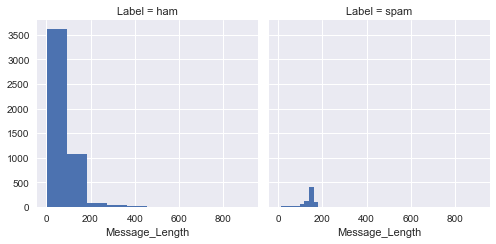

In [7]:
# histogram of the Message_Length
f = sns.FacetGrid(data=msgs, col='Label', height=3.5)
f.map(plt.hist, 'Message_Length')
plt.show()

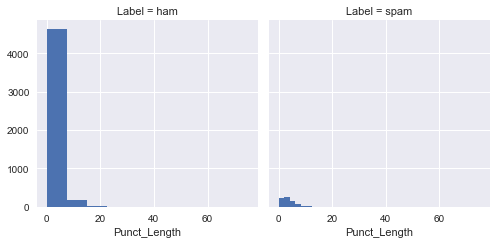

In [8]:
# histogram of the Message_Length
f = sns.FacetGrid(data=msgs, col='Label', height=3.5)
f.map(plt.hist, 'Punct_Length')
plt.show()

#### Comment:
* `Message_Length` is longer for **'spam'** messages than **'ham'** messages.
* There's no apparent difference in `Message_Length` between the **'ham'** and **'spam'** messages.

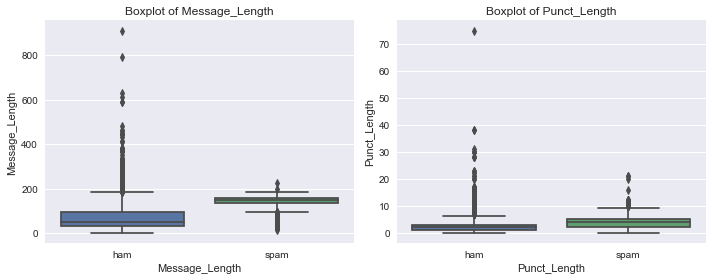

In [9]:
# boxplot
nrows, ncols = 1, 2

fig, axs = plt.subplots(nrows, ncols, figsize=(nrows * 10, ncols * 2))

for idx, col in enumerate(['Message_Length', 'Punct_Length']):
    ax = axs[idx]
    sns.boxplot(x='Label', y=col, data=msgs, ax=ax)
    ax.set(title=f"Boxplot of {col}", xlabel=col)
    
fig.tight_layout()
plt.show()

#### Comment:
* There are outliers in the `Message_Length` and `Punct_Length` **ham** messages.

In [10]:
X = msgs.drop(columns=['Message', 'Label'])       # independent features
y = msgs['Label']                                 # target 

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier())
])

In [15]:
# train model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('clf', RandomForestClassifier())])

In [16]:
# predict
rf_pred = rf_pipe.predict(X_test)

In [17]:
from sklearn import metrics

In [18]:
# Random Forests
classification_report = metrics.classification_report(y_test, rf_pred)
confusion_matrix = metrics.confusion_matrix(y_test, rf_pred)

print(f"Classification Report: \n{classification_report} \n\nConfusion Matrix: \n{confusion_matrix})")

Classification Report: 
              precision    recall  f1-score   support

         ham       0.92      0.94      0.93       962
        spam       0.56      0.50      0.53       153

    accuracy                           0.88      1115
   macro avg       0.74      0.72      0.73      1115
weighted avg       0.87      0.88      0.87      1115
 

Confusion Matrix: 
[[901  61]
 [ 76  77]])


In [19]:
msgs.head(2)

,Message,Label,Message_Length,Punct_Length
0,"Go until jurong point, crazy.. Available only ...",ham,111,4
1,Ok lar... Joking wif u oni...,ham,29,2


In [20]:
X = msgs['Message']
y = msgs['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
rf_pipe = {'rf': Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', RandomForestClassifier())
    ])}

mnb_pipe = {'mnb': Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', MultinomialNB())
    ])}

svc_pipe = {'svc': Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', SVC())
    ])}

ada_pipe = {'ada': Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', AdaBoostClassifier())
    ])}

grad_boost_pipe = {'grad_boost': Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', GradientBoostingClassifier())
    ])}

models = [rf_pipe, mnb_pipe, svc_pipe, ada_pipe, grad_boost_pipe]

In [23]:
for model_name in models:
    for key, estimator in model_name.items():
        # fit the model
        estimator.fit(X_train, y_train)
    
        # make predictions
        pred = estimator.predict(X_test)

        classification_report = metrics.classification_report(y_test, pred)
        confusion_matrix = metrics.confusion_matrix(y_test, pred)

        print(f"Model name: {key}")
        print(f"Classification Report: \n{classification_report} \n\nConfusion Matrix: \n{confusion_matrix})")
        print("===" * 30)

Model name: rf
Classification Report: 
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       962
        spam       1.00      0.83      0.91       153

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115
 

Confusion Matrix: 
[[962   0]
 [ 26 127]])
Model name: mnb
Classification Report: 
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       962
        spam       1.00      0.78      0.88       153

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115
 

Confusion Matrix: 
[[962   0]
 [ 34 119]])
Model name: svc
Classification Report: 
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       962
        spam       1.00     

### Tune the models.

In [24]:
y_binary = msgs['Label']
y_binary = y_binary.map({'spam': 1, 'ham': 0})

In [25]:
from sklearn.model_selection import RandomizedSearchCV

In [26]:
tfidf_vec = TfidfVectorizer(analyzer=clean_doc)
X_vec = tfidf_vec.fit_transform(X)

In [27]:
from scipy import stats

rf_params = dict(n_estimators=[10, 20, 40, 50, 70, 100, 110, 120, 130, 150], min_samples_leaf=np.arange(1, 15, 2))

svc_params = dict(C=stats.uniform(1, 10), gamma=stats.uniform(0.1, 1))

In [28]:
rf_rd_search = RandomizedSearchCV(RandomForestClassifier(), rf_params, scoring='f1')

svc_rd_search = RandomizedSearchCV(SVC(), svc_params, scoring='f1')

In [29]:
rf_rd_search.fit(X_vec, y_binary)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13]),
                                        'n_estimators': [10, 20, 40, 50, 70,
                                                         100, 110, 120, 130,
                                                         150]},
                   scoring='f1')

In [30]:
rf_rd_search.best_params_

{'n_estimators': 130, 'min_samples_leaf': 3}

In [31]:
svc_rd_search.fit(X_vec, y_binary)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001910A8C53D0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001910A8C5DC0>},
                   scoring='f1')

In [32]:
svc_rd_search.best_params_

{'C': 8.766711282900705, 'gamma': 0.25644595946275217}

In [33]:
rf_pipe = {'rf': Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', RandomForestClassifier(n_estimators= 50, min_samples_leaf= 1))
    ])}


svc_pipe = {'svc': Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', SVC(C=10.58557111792439, gamma= 0.11741959169299468))
    ])}


models = [rf_pipe, svc_pipe]

In [34]:
for model_name in models:
    for key, estimator in model_name.items():
        # fit the model
        estimator.fit(X_train, y_train)
    
        # make predictions
        pred = estimator.predict(X_test)

        classification_report = metrics.classification_report(y_test, pred)
        confusion_matrix = metrics.confusion_matrix(y_test, pred)

        print(f"Model name: {key}")
        print(f"Classification Report: \n{classification_report} \n\nConfusion Matrix: \n{confusion_matrix})")
        print("===" * 30)

Model name: rf
Classification Report: 
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       962
        spam       0.99      0.84      0.91       153

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115
 

Confusion Matrix: 
[[961   1]
 [ 25 128]])
Model name: svc
Classification Report: 
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       962
        spam       0.99      0.92      0.95       153

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115
 

Confusion Matrix: 
[[960   2]
 [ 12 141]])


In [35]:
clf = Pipeline([
    ('bow_tfidf', TfidfVectorizer(analyzer=clean_doc)),
    ('clf', SVC(C=10.58557111792439, gamma= 0.11741959169299468))
    ])

clf.fit(X, y)

Pipeline(steps=[('bow_tfidf',
                 TfidfVectorizer(analyzer=<function clean_doc at 0x0000019104B51550>)),
                ('clf', SVC(C=10.58557111792439, gamma=0.11741959169299468))])

In [36]:
import pickle
# pickle.format_version

# save model
with open("models/svc_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)

In [37]:
# load model
with open("models/svc_classifier.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [38]:
# use the loaded model

msg = msgs['Message'][6]
msg

'Even my brother is not like to speak with me. They treat me like aids patent.'

In [39]:
loaded_model.predict([msg])

array(['ham'], dtype=object)

In [40]:
msg = msgs['Message'][5567]
msg

'This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.'

In [41]:
loaded_model.predict([msg])

array(['spam'], dtype=object)